<a href="https://colab.research.google.com/github/punsisi2018861/forcastor-project/blob/main/Forcastor_NN_Experiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# importing necessary Python libraries
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import plotly.express as px
#import plotly.offline as pyoff
import plotly.graph_objs as go 
#import plotly.figure_factory as ff

# avoid displaying warnings
import warnings
warnings.filterwarnings("ignore")

#import machine learning related libraries
from sklearn.svm import SVC
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, cross_val_score, train_test_split, GridSearchCV, cross_validate
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from sklearn.cluster import KMeans
import xgboost as xgb
import time

from sklearn.preprocessing import MinMaxScaler

# Loading the data
df = pd.read_csv('/content/drive/My Drive/Forcasta/online_retail_II.csv')

# Rename the following columns: 
#    Invoice to InvoiceNo
#    Customer ID to CustomerID
#    Price to UnitPrice

df.rename(columns={'Invoice':'InvoiceNo', 'Customer ID':'CustomerID', 'Price':'UnitPrice'}, inplace=True)

df_data = df.dropna()
df_data.InvoiceDate = pd.to_datetime(df_data.InvoiceDate)
df_data['InvoiceYearMonth'] = df_data['InvoiceDate'].map(lambda date: 100*date.year + date.month)
df_data['Revenue'] = df_data.UnitPrice * df_data.Quantity
ctm_revenue = df_data.groupby('InvoiceYearMonth').Revenue.sum().reset_index()

ctm_bhvr_dt = df_data[(df_data.InvoiceDate < pd.Timestamp(2011,9,1)) & 
      (df_data.InvoiceDate >= pd.Timestamp(2009,12,1))].reset_index(drop=True)


ctm_next_quarter = df_data[(df_data.InvoiceDate < pd.Timestamp(2011,12,1)) & 
      (df_data.InvoiceDate >= pd.Timestamp(2011,9,1))].reset_index(drop=True)

# Get the distinct customers in the dataframe ctm_bhvr_dt
ctm_dt = pd.DataFrame(ctm_bhvr_dt['CustomerID'].unique())

# Rename the column to CustomerID.
ctm_dt.columns = ['CustomerID']

# Create a dataframe with CustomerID and customers first purchase 
# date in ctm_next_quarter
ctm_1st_purchase_in_next_quarter = ctm_next_quarter.groupby('CustomerID').InvoiceDate.min().reset_index()
ctm_1st_purchase_in_next_quarter.columns = ['CustomerID','MinPurchaseDate']

ctm_last_purchase_bhvr_dt = ctm_bhvr_dt.groupby('CustomerID').InvoiceDate.max().reset_index()
ctm_last_purchase_bhvr_dt.columns = ['CustomerID','MaxPurchaseDate']

# Merge two dataframes ctm_last_purchase_bhvr_dt and ctm_1st_purchase_in_next_quarter
ctm_purchase_dates = pd.merge(ctm_last_purchase_bhvr_dt, ctm_1st_purchase_in_next_quarter, on='CustomerID', 
                              how='left')

ctm_purchase_dates['NextPurchaseDay'] = (ctm_purchase_dates['MinPurchaseDate'] - ctm_purchase_dates['MaxPurchaseDate']).dt.days

# merge with ctm_dt 
ctm_dt = pd.merge(ctm_dt, ctm_purchase_dates[['CustomerID','NextPurchaseDay']], on='CustomerID', how='left')

ctm_dt = ctm_dt.fillna(9999)

ctm_max_purchase = ctm_bhvr_dt.groupby('CustomerID').InvoiceDate.max().reset_index()
ctm_max_purchase.columns = ['CustomerID','MaxPurchaseDate']

# Find the recency in days 
ctm_max_purchase['Recency'] = (ctm_max_purchase['MaxPurchaseDate'].max() - ctm_max_purchase['MaxPurchaseDate']).dt.days

# Merge the dataframes ctm_dt and ctm_max_purchase[['CustomerID', 'Recency']] on the CustomerID column.
ctm_dt = pd.merge(ctm_dt, ctm_max_purchase[['CustomerID', 'Recency']], on='CustomerID')

number_of_clusters = 4

kmeans = KMeans(n_clusters=number_of_clusters)
kmeans.fit(ctm_dt[['Recency']])
ctm_dt['RecencyCluster'] = kmeans.predict(ctm_dt[['Recency']])

def order_cluster(df, target_field_name, cluster_field_name, ascending):
    """
    INPUT:
        - df                  - pandas DataFrame
        - target_field_name   - str - A column in the pandas DataFrame df
        - cluster_field_name  - str - Expected to be a column in the pandas DataFrame df
        - ascending           - Boolean
        
    OUTPUT:
        - df_final            - pandas DataFrame with target_field_name and cluster_field_name as columns
    
    """
    # Add the string "new_" to cluster_field_name
    new_cluster_field_name = "new_" + cluster_field_name
    
    # Create a new dataframe by grouping the input dataframe by cluster_field_name and extract target_field_name 
    # and find the mean
    df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()
    
    # Sort the new dataframe df_new, by target_field_name in descending order
    df_new = df_new.sort_values(by=target_field_name, ascending=ascending).reset_index(drop=True)
    
    # Create a new column in df_new with column name index and assign it values to df_new.index
    df_new["index"] = df_new.index
    
    # Create a new dataframe by merging input dataframe df and part of the columns of df_new based on 
    # cluster_field_name
    df_final = pd.merge(df, df_new[[cluster_field_name, "index"]], on=cluster_field_name)
    
    # Update the dataframe df_final by deleting the column cluster_field_name
    df_final = df_final.drop([cluster_field_name], axis=1)
    
    # Rename the column index to cluster_field_name
    df_final = df_final.rename(columns={"index": cluster_field_name})
    
    return df_final

ctm_dt = order_cluster(ctm_dt, 'Recency', 'RecencyCluster', False)

#get order counts for each user and create a dataframe with it
ctm_frequency = df_data.groupby('CustomerID').InvoiceDate.count().reset_index()
ctm_frequency.columns = ['CustomerID','Frequency']

#add this data to our main ctm_dt
ctm_dt = pd.merge(ctm_dt, ctm_frequency, on='CustomerID')

kmeans = KMeans(n_clusters=number_of_clusters)
kmeans.fit(ctm_dt[['Frequency']])
ctm_dt['FrequencyCluster'] = kmeans.predict(ctm_dt[['Frequency']])

ctm_dt = order_cluster(ctm_dt, 'Frequency', 'FrequencyCluster', False)

ctm_revenue = df_data.groupby('CustomerID').Revenue.sum().reset_index()

#merge it with our ctm_dt
ctm_dt = pd.merge(ctm_dt, ctm_revenue, on='CustomerID')

#apply clustering
kmeans = KMeans(n_clusters=number_of_clusters)
kmeans.fit(ctm_dt[['Revenue']])
ctm_dt['RevenueCluster'] = kmeans.predict(ctm_dt[['Revenue']])

#order the cluster numbers
ctm_dt = order_cluster(ctm_dt, 'Revenue', 'RevenueCluster', True)

#calculate overall score and use mean() to see details
ctm_dt['OverallScore'] = ctm_dt['RecencyCluster'] + ctm_dt['FrequencyCluster'] + ctm_dt['RevenueCluster']
ctm_dt.groupby('OverallScore')['Recency','Frequency','Revenue'].mean()

ctm_dt['Segment'] = 'Low-Value'
ctm_dt.loc[ctm_dt['OverallScore'] > 4, 'Segment'] = 'Mid-Value'
ctm_dt.loc[ctm_dt['OverallScore'] > 6, 'Segment'] = 'High-Value'

#create ctm_class as a copy of ctm_dt before applying get_dummies
ctm_class = ctm_dt.copy()
ctm_class = pd.get_dummies(ctm_class)
ctm_class.head()

ctm_class['NextPurchaseDayRange'] = 4  ## first week
ctm_class.loc[ctm_class.NextPurchaseDay>7,'NextPurchaseDayRange'] = 3 # second week
ctm_class.loc[ctm_class.NextPurchaseDay>14,'NextPurchaseDayRange'] = 2 # 3rd week
ctm_class.loc[ctm_class.NextPurchaseDay>30,'NextPurchaseDayRange'] = 1 # 4th week
ctm_class.loc[ctm_class.NextPurchaseDay>90,'NextPurchaseDayRange'] = 0 # more than 3 months

# corr_matrix = ctm_class[ctm_class.columns].corr()
# corr_df = pd.DataFrame(corr_matrix.min())
# corr_df.columns = ['MinCorrelationCoeff']
# corr_df['MaxCorrelationCoeff'] = corr_matrix[corr_matrix < 1].max()

ctm_class.head()




,CustomerID,NextPurchaseDay,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,OverallScore,Segment_High-Value,Segment_Low-Value,Segment_Mid-Value,NextPurchaseDayRange
0,13085.0,9999.0,57,3,92,3,1459.46,0,6,0,0,1,0
1,18087.0,46.0,44,3,95,3,14411.62,0,6,0,0,1,1
2,17519.0,116.0,33,3,224,3,5102.80,0,6,0,0,1,0
3,12362.0,40.0,12,3,275,3,5284.58,0,6,0,0,1,1
4,15712.0,38.0,9,3,167,3,3467.46,0,6,0,0,1,1


In [ ]:
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
ctm_class = ctm_class.drop('NextPurchaseDay', axis=1)
ctm_class = ctm_class.drop('CustomerID', axis=1)
X, y = ctm_class.drop('NextPurchaseDayRange',axis=1), ctm_class.NextPurchaseDayRange
# y = to_categorical(y)

# encode class values as integers
encoder = LabelEncoder()
encoder.fit(y)
y = encoder.transform(y)

# convert integers to dummy variables (i.e. one hot encoded)
y = to_categorical(y)

sc = MinMaxScaler(feature_range=(0, 1))
X = sc.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=44)

In [ ]:
import keras.backend as K
K.clear_session()

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
# Define the model
model = Sequential()
model.add(Dense(500, input_shape = (10,), activation='relu',kernel_initializer='random_normal'))
# model.add(Dropout(0.2))

model.add(Dense(700, activation='relu',kernel_initializer='random_normal'))
model.add(Dropout(0.2))

model.add(Dense(100, activation='relu',kernel_initializer='random_normal'))
model.add(Dropout(0.2))

# model.add(Dense(50, activation='relu',kernel_initializer='random_normal'))
# model.add(Dropout(0.2))

# model.add(Dense(50, activation='sigmoid'))
# model.add(Dropout(0.2))
# model.add(Dense(50, activation='relu'))
# model.add(Dropout(0.2))

model.add(Dense(5, activation='sigmoid'))


model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])

In [ ]:
# Train the model
model.fit(X_train,y_train,batch_size = 32,
          epochs=20,
          validation_data=(X_test, y_test))

Epoch 1/20
133/133 [==============================] - 8s 6ms/step - loss: 0.4818 - accuracy: 0.8132 - val_loss: 0.3736 - val_accuracy: 0.8382
Epoch 2/20
133/133 [==============================] - 1s 5ms/step - loss: 0.3639 - accuracy: 0.8367 - val_loss: 0.3470 - val_accuracy: 0.8391
Epoch 3/20
133/133 [==============================] - 1s 5ms/step - loss: 0.3455 - accuracy: 0.8396 - val_loss: 0.3419 - val_accuracy: 0.8457
Epoch 4/20
133/133 [==============================] - 1s 4ms/step - loss: 0.3424 - accuracy: 0.8370 - val_loss: 0.3429 - val_accuracy: 0.8410
Epoch 5/20
133/133 [==============================] - 1s 4ms/step - loss: 0.3385 - accuracy: 0.8438 - val_loss: 0.3370 - val_accuracy: 0.8495
Epoch 6/20
133/133 [==============================] - 1s 4ms/step - loss: 0.3383 - accuracy: 0.8377 - val_loss: 0.3346 - val_accuracy: 0.8438
Epoch 7/20
133/133 [==============================] - 1s 4ms/step - loss: 0.3376 - accuracy: 0.8400 - val_loss: 0.3330 - val_accuracy: 0.8401
Epoch 

In [ ]:

ctm_class = ctm_class.drop('NextPurchaseDay', axis=1)

X, y = ctm_class.drop('NextPurchaseDayRange', axis=1), ctm_class.NextPurchaseDayRange
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=None, shuffle=True)

sc = MinMaxScaler()
X = sc.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=44)

X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

In [ ]:
X_train.shape


(4251, 1, 11)

In [ ]:
X_test.shape

(1063, 1, 11)

In [ ]:
ctm_class = ctm_class.drop('NextPurchaseDay', axis=1)
ctm_class = ctm_class.drop('CustomerID', axis=1)
X, y = ctm_class.drop('NextPurchaseDayRange',axis=1), ctm_class.NextPurchaseDayRange
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=44)

In [ ]:
# Create an array of models
models = []
models.append(("LogisticRegression", LogisticRegression()))
models.append(("GaussianNB", GaussianNB()))
models.append(("RandomForestClassifier", RandomForestClassifier()))
models.append(("SVC", SVC()))
models.append(("DecisionTreeClassifier", DecisionTreeClassifier()))
models.append(("xgb.XGBClassifier", xgb.XGBClassifier(eval_metric='mlogloss')))
models.append(("KNeighborsClassifier", KNeighborsClassifier()))

In [ ]:
#measure the accuracy 
for name,model in models:
    kfold = KFold(n_splits=2, shuffle=True, random_state=22)
    cv_result = cross_val_score(model,X_train,y_train, cv = kfold,scoring = "accuracy")
    print(name, cv_result)

LogisticRegression [0.82784572 0.84988235]
GaussianNB [0.77375353 0.81788235]
RandomForestClassifier [0.83207902 0.85129412]
SVC [0.81185325 0.82164706]
DecisionTreeClassifier [0.80573848 0.83952941]
xgb.XGBClassifier [0.82690499 0.84235294]
KNeighborsClassifier [0.7953904  0.82870588]


In [ ]:

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

model = Sequential()

model.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 11)))
model.add(Dropout(0.2))

model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))

# model.add(LSTM(units = 50, return_sequences = True))
# model.add(Dropout(0.2))

model.add(LSTM(units = 50))
model.add(Dropout(0.2))

model.add(Dense(units = 1,activation='softmax',))

model.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics = ['accuracy'])


history= model.fit(X_train, y_train, epochs = 50, batch_size = 32)

Epoch 1/50
133/133 [==============================] - 6s 5ms/step - loss: 0.3917 - accuracy: 0.8085
Epoch 2/50
133/133 [==============================] - 1s 5ms/step - loss: 0.2783 - accuracy: 0.8069
Epoch 3/50
133/133 [==============================] - 1s 5ms/step - loss: 0.2395 - accuracy: 0.8297
Epoch 4/50
133/133 [==============================] - 1s 7ms/step - loss: 0.2305 - accuracy: 0.8393
Epoch 5/50
133/133 [==============================] - 1s 7ms/step - loss: 0.2315 - accuracy: 0.8375
Epoch 6/50
133/133 [==============================] - 1s 8ms/step - loss: 0.2267 - accuracy: 0.8375
Epoch 7/50
133/133 [==============================] - 1s 8ms/step - loss: 0.2263 - accuracy: 0.8363
Epoch 8/50
133/133 [==============================] - 1s 6ms/step - loss: 0.2234 - accuracy: 0.8407
Epoch 9/50
133/133 [==============================] - 1s 5ms/step - loss: 0.2246 - accuracy: 0.8396
Epoch 10/50
133/133 [==============================] - 1s 5ms/step - loss: 0.2233 - accuracy: 0.8414

In [ ]:
eval_model = model.evaluate(X_train, y_train)
eval_model

133/133 [==============================] - 4s 8ms/step - loss: 0.1360 - accuracy: 0.8398


[0.13603532314300537, 0.8398023843765259]

KeyError: ignored

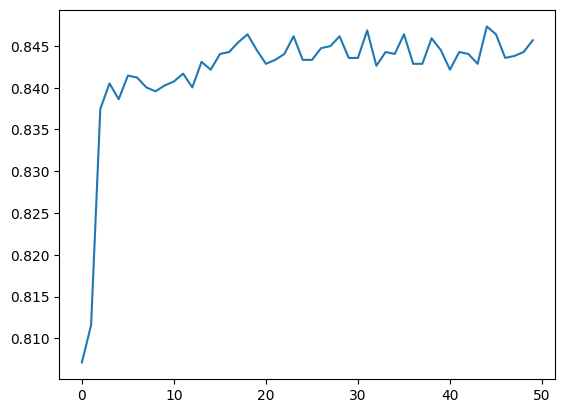

In [ ]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")